In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.style.use("grayscale")

In [3]:
df = pd.read_csv("./space/pulsar_stars.csv")

In [4]:
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [5]:
df["target_class"].value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

In [6]:
X = df.drop(["target_class"], axis=1).values
X.shape

(17898, 8)

In [7]:
y = df["target_class"]
y.shape

(17898,)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.3, )
X_train.shape, X_test.shape

((12528, 8), (5370, 8))

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_train_std.shape, X_test_std.shape

((12528, 8), (5370, 8))

In [23]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression().fit(X_train_std, y_train)
score = {"LogisticRegression" : {"Train" : log_model.score(X_train_std, y_train),
                               "Test"  : log_model.score(X_test_std, y_test)}}
pd.DataFrame(score)

,LogisticRegression
Test,0.979888
Train,0.978847


In [25]:
from algorithms import SimpleESClassifier
from algorithms import GeneticESClassifier
from algorithms import NaturalESClassifier
from algorithms import DifferentialEvolutionClassifier

def score(objective, iterations=100):
    bounds = np.array([(-20, 20)] * (1 + X_train_std.shape[1]))

    ses = SimpleESClassifier(objective=objective, n_iter=iterations, random_state=0)
    ges = GeneticESClassifier(objective=objective, n_iter=iterations, random_state=0)
    nes = NaturalESClassifier(objective=objective, n_iter=iterations, random_state=0)
    dev = DifferentialEvolutionClassifier(objective=objective, n_iter=iterations * 10, random_state=0, bounds=bounds)

    ses.fit(X_train_std, y_train)
    ges.fit(X_train_std, y_train)
    nes.fit(X_train_std, y_train)
    dev.fit(X_train_std, y_train)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0][0].set_title("Simple ES")
    axes[0][0].plot(range(iterations), ses.history_)
    axes[0][1].set_title("Genetic ES")
    axes[0][1].plot(range(iterations), ges.history_)
    axes[1][0].set_title("Natural ES")
    axes[1][0].plot(range(iterations), nes.history_)
    axes[1][1].set_title("Differential Evolution")
    axes[1][1].plot(range(iterations * 10), dev.history_)

    score = {"SimpleES" : {"Train" : ses.score(X_train_std, y_train),
                           "Test"  : ses.score(X_test_std, y_test)},
             "GeneticES" : {"Train" : ges.score(X_train_std, y_train),
                            "Test"  : ges.score(X_test_std, y_test)},
             "NaturalES" : {"Train" : nes.score(X_train_std, y_train),
                            "Test"  : nes.score(X_test_std, y_test)},
             "DifferentialEvolution" : {"Train" : dev.score(X_train_std, y_train),
                                        "Test"  : dev.score(X_test_std, y_test)}}
    return pd.DataFrame(score)

100%|██████████| 1000/1000 [00:26<00:00, 38.02it/s]


,SimpleES,GeneticES,NaturalES,DifferentialEvolution
Train,0.979167,0.979087,0.976453,0.979486
Test,0.980261,0.979888,0.978957,0.979702


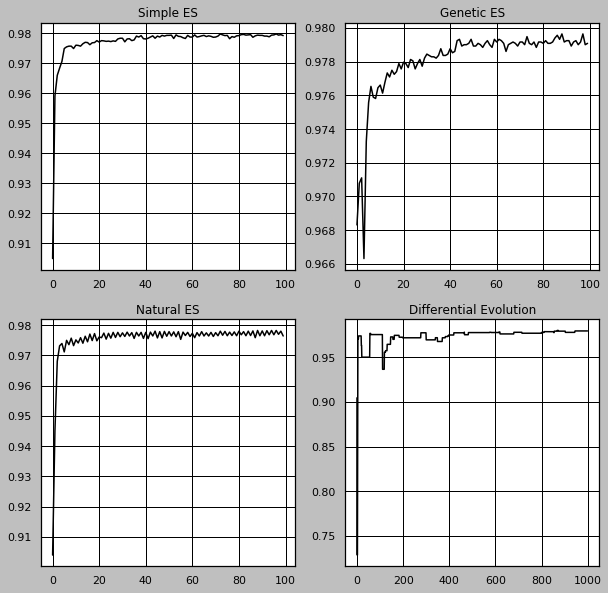

In [26]:
from objectives import CrossEntropyObjective

score(CrossEntropyObjective())

Let's try tweaking the NaturalES hyperparameters.

100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


0.9780260707635009

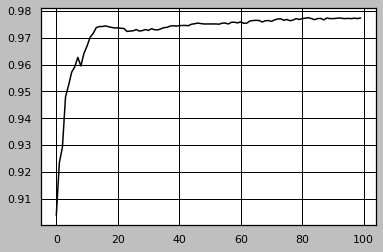

In [31]:
import scipy
from sklearn.model_selection import GridSearchCV

iterations = 100

nes = NaturalESClassifier(objective=CrossEntropyObjective(), n_iter=iterations, random_state=0, sigma=0.1, alpha=0.01)
nes.fit(X_train_std, y_train)
plt.plot(range(iterations), nes.history_)
nes.score(X_test_std, y_test)